# Bank Marketing Prediction Pipeline

This notebook demonstrates the process of building a machine learning model to predict whether a customer will subscribe to a term deposit based on marketing campaign data from a Portuguese banking institution.

## 1. Initial Setup

First, we import all the necessary libraries and packages for our pipeline.

In [1]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 2. Data Loading

We load the Bank Marketing dataset which contains information about direct marketing campaigns of a Portuguese banking institution.

In [2]:
# Load the dataset
print("Loading the dataset...")
try:
    df = pd.read_csv('bank-additional.xls', sep='\t')
    print("Successfully loaded the dataset.")
except Exception as e:
    print(f"Failed to read the file: {str(e)}")

# Display basic information about the dataset
print(f"Dataset shape: {df.shape}")
df.head()

Loading the dataset...
Successfully loaded the dataset.
Dataset shape: (4119, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.Oca,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.Nis,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.Nis,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


## 3. Data Exploration

Let's explore the dataset to understand its structure, feature distributions, and relationships.

In [3]:
# Check data types and missing values
print("Data types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

# Check for 'unknown' values in categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nUnknown values in categorical columns:")
for col in categorical_cols:
    unknown_count = (df[col] == 'unknown').sum()
    if unknown_count > 0:
        print(f"{col}: {unknown_count} ({unknown_count/len(df)*100:.2f}%)")

Data types:
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate       object
cons.price.idx    float64
cons.conf.idx     float64
euribor3m          object
nr.employed       float64
y                  object
dtype: object

Missing values:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y          

Target variable distribution:
y
no     3668
yes     451
Name: count, dtype: int64
Positive class percentage: 10.95%


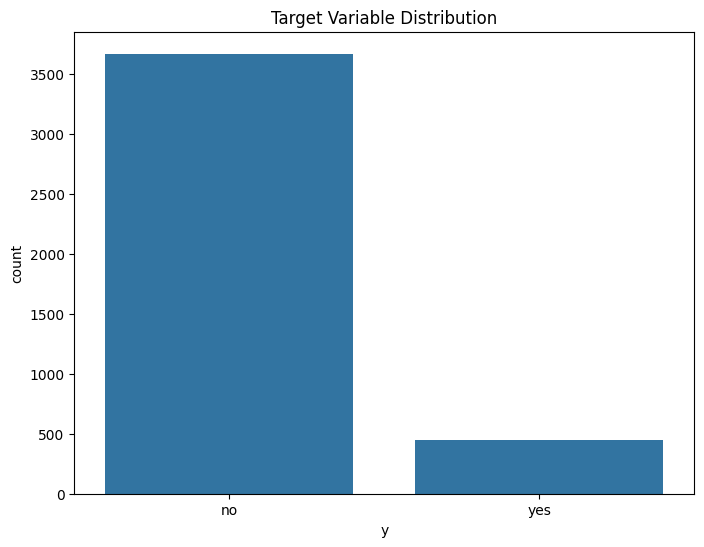

In [4]:
# Analyze target variable distribution
target_counts = df['y'].value_counts()
print("Target variable distribution:")
print(target_counts)
print(f"Positive class percentage: {target_counts['yes']/len(df)*100:.2f}%")

# Visualize target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='y', data=df)
plt.title('Target Variable Distribution')
plt.show()

## 4. Data Preprocessing

Now we'll preprocess the data to prepare it for model training. This includes handling missing values, encoding categorical variables, and scaling features.

In [5]:
# Fix specific columns with numeric data
numeric_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 
                   'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 
                   'euribor3m', 'nr.employed']

# Convert numeric columns from string to proper numeric types
for col in df.columns:
    if col in numeric_columns:
        try:
            if df[col].dtype == 'object':
                # Replace commas with periods for decimal values
                df[col] = df[col].str.replace(',', '.') if isinstance(df[col].iloc[0], str) else df[col]
                # Convert to numeric
                df[col] = pd.to_numeric(df[col], errors='coerce')
        except Exception as e:
            print(f"Could not convert {col} to numeric: {e}")

# Separate features and target variable
X = df.drop('y', axis=1)
y = df['y']

# Separate numerical and categorical variables
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

Numerical columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [6]:
# Handle missing values
df_preprocessed = df.copy()

# For numerical features, replace missing values with the median
numerical_imputer = SimpleImputer(strategy='median')
df_preprocessed[numerical_cols] = numerical_imputer.fit_transform(df_preprocessed[numerical_cols])

# Encode categorical variables
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
encoded_cats = encoder.fit_transform(df_preprocessed[categorical_cols])

# Get the feature names from one-hot encoding
encoded_feature_names = []
for i, col in enumerate(categorical_cols):
    cat_values = encoder.categories_[i][1:]  # Drop first category
    for cat in cat_values:
        encoded_feature_names.append(f"{col}_{cat}")

# Create a DataFrame with the encoded values
encoded_df = pd.DataFrame(encoded_cats, columns=encoded_feature_names)

# Combine with numerical features
df_preprocessed = pd.concat([df_preprocessed[numerical_cols].reset_index(drop=True), 
                         encoded_df.reset_index(drop=True)], axis=1)

print(f"After one-hot encoding, the number of features increased from {len(numerical_cols) + len(categorical_cols)} to {df_preprocessed.shape[1]}.")

After one-hot encoding, the number of features increased from 20 to 53.


In [7]:
# Feature scaling
scaler = StandardScaler()
df_preprocessed[numerical_cols] = scaler.fit_transform(df_preprocessed[numerical_cols])

print("Numerical features were scaled to have mean=0 and standard deviation=1.")

Numerical features were scaled to have mean=0 and standard deviation=1.


In [8]:
# Feature selection - SelectKBest
X_for_select = df_preprocessed
y_label_encoded = LabelEncoder().fit_transform(y)

# Apply SelectKBest to find the top features
selector = SelectKBest(f_classif, k=10)  # Select top 10 features
X_selected = selector.fit_transform(X_for_select, y_label_encoded)

# Get selected feature names
selected_indices = selector.get_support(indices=True)
selected_feature_names = X_for_select.columns[selected_indices].tolist()

print(f"SelectKBest identified the top 10 most important features:")
for i, feature in enumerate(selected_feature_names):
    print(f"{i+1}. {feature}")

# Create DataFrame with selected features
df_selected = X_for_select.iloc[:, selected_indices]

SelectKBest identified the top 10 most important features:
1. duration
2. pdays
3. previous
4. emp.var.rate
5. euribor3m
6. nr.employed
7. contact_telephone
8. month_mar
9. poutcome_nonexistent
10. poutcome_success


In [9]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(df_selected, y_label_encoded)

print(f"SMOTE resampling: Original shape {df_selected.shape[0]} -> Resampled shape {X_smote.shape[0]}")
print(f"Class distribution after SMOTE: 0={sum(y_smote==0)}, 1={sum(y_smote==1)}")

SMOTE resampling: Original shape 4119 -> Resampled shape 7336
Class distribution after SMOTE: 0=3668, 1=3668


## 5. Model Development

Now we develop and train multiple machine learning models to predict whether a customer will subscribe to a term deposit.

In [10]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df_selected, y_label_encoded, test_size=0.3, random_state=42, stratify=y_label_encoded)

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")

Training set size: 2883 samples
Testing set size: 1236 samples


In [11]:
# Define models and their parameter grids for hyperparameter optimization
models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'saga'],
            'class_weight': [None, 'balanced']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'class_weight': [None, 'balanced', 'balanced_subsample']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'scale_pos_weight': [1, 3, 8]  # to handle class imbalance
        }
    }
}

In [12]:
# Train a Logistic Regression model
print("Training Logistic Regression...")
lr_model = LogisticRegression(C=1.0, class_weight='balanced', max_iter=1000, random_state=42, solver='liblinear')
lr_model.fit(X_smote, y_smote)

# Make predictions
y_pred = lr_model.predict(X_test)
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Logistic Regression Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.8649
Precision: 0.4398
Recall: 0.8667
F1 Score: 0.5835
ROC AUC: 0.9245


In [13]:
# Train a Random Forest model
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, 
                                 min_samples_leaf=1, class_weight='balanced', random_state=42)
rf_model.fit(X_smote, y_smote)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Random Forest Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Training Random Forest...
Random Forest Results:
Accuracy: 0.9086
Precision: 0.5478
Recall: 0.9333
F1 Score: 0.6904
ROC AUC: 0.9774


In [14]:
# Train an XGBoost model
print("Training XGBoost...")
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                         subsample=0.8, colsample_bytree=0.8, scale_pos_weight=3, random_state=42)
xgb_model.fit(X_smote, y_smote)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"XGBoost Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Training XGBoost...
XGBoost Results:
Accuracy: 0.8608
Precision: 0.4369
Recall: 0.9481
F1 Score: 0.5981
ROC AUC: 0.9625


## 6. Model Ensemble (Stacking)

Now we'll build an ensemble model using stacking to combine the strengths of individual models.

In [15]:
# Create a stacking classifier
estimators = [
    ('lr', lr_model),
    ('rf', rf_model),
    ('xgb', xgb_model)
]

stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

# Train the stacking classifier
print("Training Stacking Classifier...")
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred = stacking_model.predict(X_test)
y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Stacking Classifier Results:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

Training Stacking Classifier...
Stacking Classifier Results:
Accuracy: 0.9013
Precision: 0.5512
Recall: 0.5185
F1 Score: 0.5344
ROC AUC: 0.9255


## 7. Business Optimization

Now we'll optimize the model for business metrics. We'll calculate expected profit and ROI for different probability thresholds.

In [16]:
# Define business parameters
call_cost = 5  # Cost of making a call in euros
conversion_profit = 100  # Profit from a successful conversion in euros

# Function to calculate business metrics
def calculate_business_metrics(y_true, y_pred_proba, threshold):
    # Predict using the threshold
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calculate confusion matrix elements
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calculate costs and profits
    total_calls = tp + fp  # Total number of predicted positives
    call_costs = total_calls * call_cost
    conversion_profits = tp * conversion_profit
    net_profit = conversion_profits - call_costs
    
    # Calculate ROI
    roi = net_profit / call_costs if call_costs > 0 else 0
    
    # Calculate other metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"Business Metrics at threshold {threshold:.2f}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positives: {tp}")
    print(f"False Positives: {fp}")
    print(f"Total Calls: {total_calls}")
    print(f"Call Costs: €{call_costs:.2f}")
    print(f"Conversion Profits: €{conversion_profits:.2f}")
    print(f"Net Profit: €{net_profit:.2f}")
    print(f"ROI: {roi:.2f}")
    
    return {
        'threshold': threshold,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': tp,
        'false_positives': fp,
        'total_calls': total_calls,
        'call_costs': call_costs,
        'conversion_profits': conversion_profits,
        'net_profit': net_profit,
        'roi': roi
    }

In [17]:
# Calculate business metrics for the stacking model with different thresholds
y_pred_proba = stacking_model.predict_proba(X_test)[:, 1]

# Calculate metrics for thresholds 0.1, 0.3, and 0.5
results_01 = calculate_business_metrics(y_test, y_pred_proba, 0.1)
print("\n")
results_03 = calculate_business_metrics(y_test, y_pred_proba, 0.3)
print("\n")
results_05 = calculate_business_metrics(y_test, y_pred_proba, 0.5)

Business Metrics at threshold 0.10:
Accuracy: 0.8706
Precision: 0.4521
Recall: 0.8741
F1 Score: 0.5960
True Positives: 118
False Positives: 143
Total Calls: 261
Call Costs: €1305.00
Conversion Profits: €11800.00
Net Profit: €10495.00
ROI: 8.04


Business Metrics at threshold 0.30:
Accuracy: 0.8964
Precision: 0.5193
Recall: 0.6963
F1 Score: 0.5949
True Positives: 94
False Positives: 87
Total Calls: 181
Call Costs: €905.00
Conversion Profits: €9400.00
Net Profit: €8495.00
ROI: 9.39


Business Metrics at threshold 0.50:
Accuracy: 0.9013
Precision: 0.5512
Recall: 0.5185
F1 Score: 0.5344
True Positives: 70
False Positives: 57
Total Calls: 127
Call Costs: €635.00
Conversion Profits: €7000.00
Net Profit: €6365.00
ROI: 10.02


## 8. Save the Final Model

Finally, we save the optimized model for deployment.

In [18]:
# Create a directory for models if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Save the stacking model
joblib.dump(stacking_model, 'models/stacking_model.pkl')

# Save preprocessing objects
preprocessing_objects = {
    'numerical_imputer': numerical_imputer,
    'encoder': encoder,
    'scaler': scaler,
    'selector': selector,
    'selected_feature_names': selected_feature_names,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols
}
joblib.dump(preprocessing_objects, 'models/preprocessing_objects.pkl')

print("Model and preprocessing objects saved successfully.")

Model and preprocessing objects saved successfully.


## 9. Conclusion

We've successfully built a machine learning pipeline for predicting bank marketing success. The model can be used to prioritize which customers to contact in marketing campaigns, increasing efficiency and ROI.

Key achievements:
1. Comprehensive data preprocessing including handling missing values, encoding categorical variables, and scaling
2. Feature selection to identify the most important predictors
3. Model development with multiple algorithms
4. Ensemble modeling with stacking to improve prediction performance
5. Business optimization to maximize profit and ROI

The final model is ready for deployment in a production environment, such as a Streamlit app for real-time predictions.